# Interferon beta stim and genetic perturbations cause changes in gene-gene correlation

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [421]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [422]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [423]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [424]:
import warnings
warnings.filterwarnings('ignore')

In [425]:
from sklearn.decomposition import PCA

In [426]:
from sklearn.preprocessing import StandardScaler

In [427]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [428]:
data_path = '/data/parameter_estimation/'

### Plotting function

In [429]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['log_count'] = np.log(df['count'])
    
    plt.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier)    
    

### Read the IFN AnnData object

In [430]:
ifn_adata = sc.read(data_path + 'interferon_data/interferon.raw.h5ad')
ifn_adata = ifn_adata[:, ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
ifn_adata.obs['cell_type'] = (ifn_adata.obs['cell'].astype(str) + ' - ' + ifn_adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


### Read CD4 AnnData object

In [431]:
cd4_adata = sc.read(data_path + 'cd4_cropseq_data/guide_singlets.h5ad')

### Figure out which genes to test for correlation using CD4 data

Only pick genes that have > 10% cells expressing the gene

In [432]:
cd4_adata.obs['target_regulator'] = cd4_adata.obs['guide1_cov'].apply(lambda x: x.split('.')[0])

In [433]:
ko_genes = cd4_adata.obs['target_regulator']

In [434]:
# Filter for genes in the IFN dataset
genes_to_test = list(set(ifn_adata.var.index.tolist()) & set(cd4_adata.obs['target_regulator'].tolist()))

In [435]:
# Read the immune genes we filtered previously
with open(data_path + 'interferon_data/immune_genes.pkl', 'rb') as f:
    immune_genes = pkl.load(f)

In [436]:
# Pick genes that have a fairly high expression
ko_gene_to_test = [gene for gene in genes_to_test if (cd4_adata[:, gene].X > 0).sum() / cd4_adata.shape[0] > 0.1]
immune_gene_to_test = [gene for gene in immune_genes if (cd4_adata[:, gene].X > 0).sum() / cd4_adata.shape[0] > 0.1]

In [437]:
with open(data_path + 'interferon_data/immune_genes_to_test.pkl', 'wb') as f:
    pkl.dump(immune_gene_to_test, f)
with open(data_path + 'cd4_cropseq_data/ko_genes_to_test.pkl', 'wb') as f:
    pkl.dump(ko_gene_to_test, f)

In [442]:
filtered_cd4_adata = cd4_adata[cd4_adata.obs['target_regulator'].isin(ko_gene_to_test)]

In [443]:
filtered_cd4_adata.shape

(29245, 562)

In [447]:
filtered_cd4_adata.obs['group'].value_counts()

WT                  2980
ZNF146.36236488     850 
HOPX.56655937       825 
FUS.31184329        787 
SATB1.18415117      770 
HDAC3.141634859     749 
RBBP7.16857703      748 
MATR3.139307613     730 
ZC3H15.186501310    673 
ATF4.39521667       616 
PARP1.226385581     572 
ZNF24.35340244      540 
PHB2.6969554        527 
FOXP1.71015617      521 
IKZF1.50376659      521 
DCP1A.53292521      514 
ZNF24.35339842      512 
TFAM.58388689       495 
IRF1.132487047      471 
DPF2.65340430       420 
TOX4.21487678       419 
IRF1.132487119      402 
CREM.35188237       398 
NONO.71296973       397 
KLF6.3782035        395 
FUS.31183999        379 
SATB1.18417016      371 
TAF7.141319508      371 
NCOA4.46012894      364 
ZC3H15.186502553    358 
ID2.8682335         355 
RBBP7.16869108      351 
ARID5B.62050979     343 
ATF4.39521890       333 
TFAM.58388232       333 
XBP1.28797122       320 
DNMT1.10146475      320 
NONO.71294280       310 
XBP1.28800395       310 
ZNF593.26170086     309 


In [439]:
cd4_adata.shapea

(105203, 562)

In [441]:
cd4_adata.obs.head(5)

,concat_index,donor,multiplet,well,guide1_cov,guide2_cov,guide3_cov,guide4_cov,guide1_ce_cov,guide2_ce_cov,guide3_ce_cov,guide4_ce_cov,guide_multiplet_cov,group,n_counts,target_regulator
index,,,,,,,,,,,,,,,,
CTTTGCGGTCAACATC-8,0,IGTB1982,SNG,8,RC3H1.173961818.CTGGATTCTGGTACATACGA,nan,nan,nan,0.154435,NaN,NaN,NaN,1,RC3H1.173961818,3027,RC3H1
TGGCGCAAGGATGCGT-6,0,IGTB1762,SNG,6,MAFK.1540041.CCTGCGGGGTCTCACCAAGG,nan,nan,nan,0.005697,NaN,NaN,NaN,1,MAFK.1540041,6495,MAFK
CGAGCACGTAGAGCTG-7,0,IGTB2065,SNG,7,SRA1.140551987.AGACTGCCGTGGCCACACAA,nan,nan,nan,0.109404,NaN,NaN,NaN,1,SRA1.140551987,4386,SRA1
TGCCCATAGAGTGACC-10,0,IGTB1762,SNG,10,ZNF706.101201657.GAAACAAGGACATGACCAAA,nan,nan,nan,0.146234,NaN,NaN,NaN,1,ZNF706.101201657,5517,ZNF706
TGGACGCAGAACAATC-7,0,IGTB884,SNG,7,TFB2M.246556688.GTTGGAATGTTCCCAAGTAG,nan,nan,nan,0.119784,NaN,NaN,NaN,1,TFB2M.246556688,7523,TFB2M


In [438]:
ko_gene_to_test

['ZNF24',
 'MYC',
 'DNMT1',
 'NCOA4',
 'TFAM',
 'BCLAF1',
 'RBBP7',
 'YEATS4',
 'IRF1',
 'XBP1',
 'HDAC3',
 'MATR3',
 'PHB2',
 'HOPX',
 'ZC3H15',
 'FUS',
 'KLF6',
 'ETS1',
 'SATB1',
 'TOX4',
 'CREM',
 'FOXP1',
 'CEBPZ',
 'ZNF593',
 'ZFP36L1',
 'NONO',
 'DPF2',
 'ZNF146',
 'TAF7',
 'STAT6',
 'PARP1',
 'ARID5B',
 'IKZF1',
 'MAZ',
 'STAT3',
 'ID2',
 'DCP1A',
 'BATF',
 'ATF4']

### Function for summarizing DC results

In [215]:
def organize_dc_result(result, adata):
    
    idxs_1 = result['gene_idx_1']
    idxs_2 = result['gene_idx_2']
    
    gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
    
    df = pd.DataFrame(
        data=list(zip(
            adata.var.index[idxs_1[gene_pair_idx[:, 0]]], 
            adata.var.index[idxs_2[gene_pair_idx[:, 1]]],
            result['corr_1'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['corr_2'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['dc_pval'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['dc_fdr'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]])),
        columns=['gene_1', 'gene_2', 'corr_1', 'corr_2', 'pval', 'fdr'])
    
    return df
def organize_1d_result(result, adata):
    
    df = pd.DataFrame()
    df['gene'] = adata.var.index.tolist()
    df['de_diff'] = result['de_diff']
    df['de_pval'] = result['de_pval']
    df['de_fdr'] = result['de_fdr']
    df['dv_pval'] = result['dv_pval']
    df['dv_fdr'] = result['dv_fdr']
    return df

In [216]:
ct = 'CD4 T cells'

In [217]:
with open(data_path + 'interferon_data/stim_effect_1d_moments.pkl', 'rb') as f:
    ifn_moment_dict_1d = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_2d.pkl', 'rb') as f:
    ifn_dc_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_1d.pkl', 'rb') as f:
    ifn_de_dv_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_ci_2d.pkl', 'rb') as f:
    ifn_corr_ci = pkl.load(f)

In [348]:
ifn_dc_df = organize_dc_result(ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')], ifn_adata)
ifn_dc_df = ifn_df.query('fdr < 0.2')
ifn_regulators = ifn_dc_df['gene_1'].drop_duplicates().tolist()

In [349]:
ifn_regulators

['STAT3', 'STAT4', 'STAT6', 'IRF1', 'IRF8', 'IRF9']

### Find examples of DC without DE

In [350]:
ifn_1d_df = organize_1d_result(ifn_de_dv_result[(ct + ' - ctrl', ct + ' - stim')], ifn_adata)
nonsig_1d = ifn_1d_df.query('de_fdr > 0.1')

In [351]:
#ifn_dc_df = ifn_dc_df[ifn_dc_df['gene_1'].isin(nonsig_1d.gene.tolist())]

### Read CD4 2D result

In [352]:
guides = \
"""FOXP1.71015617
FOXP1.71041428
IFI16.159018299
IRF1.132487047
IRF1.132487119
IRF2.184418577
IRF4.394977
IRF4.397215
IRF8.85909118
IRF8.85913149
JUN.58783019
JUNB.12791833
JUNB.12791929
NCOA3.47627735
NCOA3.47634078
NCOA4.46012894
SATB1.18415117
STAT1.190997935
STAT1.190998294
STAT3.42333711
STAT5A.42292035
STAT5A.42304559
STAT6.57102489""".split()

In [375]:
cd4_results = {g:pkl.load(open(data_path + 'cd4_cropseq_data/diff_cor/{}.pkl'.format(g), 'rb'))[('WT', g)]
               for g in guides}
cd4_df = []
for g, res in cd4_results.items():
    
    df = organize_dc_result(res, cd4_adata)
    df['guide'] = g
    df['target_gene'] = g.split('.')[0]
    cd4_df.append(df)
cd4_df = pd.concat(cd4_df)\
    .query('corr_1 < 1 & corr_1 > -1 & corr_2 < 1 & corr_2 > -1')\
    .query('fdr < 1')
#cd4_df = cd4_df[cd4_df['target_gene'].isin(ifn_regulators)]

### Find some interesting cases

Correlation of IRF1 and NKFIA, FOXP1 as mediator

{'FOXP1', 'IRF1', 'IRF8', 'JUN', 'JUNB', 'NCOA4', 'SATB1', 'STAT3', 'STAT6'}


In [416]:
len(immune_gene_to_test)

281

In [413]:
len(ko_gene_to_test)

39

In [397]:
(cd4_adata[:, 'JUN'].X > 0).sum() / cd4_adata.shape[0]

0.012290524034485708

In [404]:
immune_genes

NameError: name 'immune_genes' is not defined

In [403]:
(cd4_adata[:, 'IRF8'].X > 0).sum() / cd4_adata.shape[0]

0.0007984563177856145

In [395]:
genes_to_test

['NFKBIA',
 'ZNF24',
 'MYC',
 'PREB',
 'DNMT1',
 'NCOA4',
 'TFAM',
 'BCLAF1',
 'GABPB1',
 'RBBP7',
 'YEATS4',
 'IRF1',
 'XBP1',
 'HDAC3',
 'MATR3',
 'E2F4',
 'PHB2',
 'HOPX',
 'ZC3H15',
 'FUS',
 'KLF6',
 'ETS1',
 'SATB1',
 'TOX4',
 'CREM',
 'FOXP1',
 'CEBPZ',
 'ZNF593',
 'BHLHE40',
 'ZFP36L1',
 'NONO',
 'DPF2',
 'ZNF146',
 'TAF7',
 'STAT6',
 'IRF8',
 'PARP1',
 'ARID5B',
 'IKZF1',
 'MAZ',
 'STAT3',
 'ID2',
 'DCP1A',
 'JUNB',
 'BATF',
 'ATF4',
 'JUN',
 'ARID5A']

In [384]:
'NFKBIA' in ifn_adata.var.index.tolist()

True

In [382]:
ifn_1d_df.query('gene == "NFKBIA"')

,gene,de_diff,de_pval,de_fdr,dv_pval,dv_fdr
1336,NFKBIA,0.091668,0.178182,0.295764,0.09839,0.430944


In [ ]:
cd4_df.query('gene_1 == "IRF1" & gene_2 == "NFKBIA"')

In [377]:
ifn_dc_df.sort_values('corr_2', ascending=False).query('gene_1 != "IRF8"').head(10)

,gene_1,gene_2,corr_1,corr_2,pval,fdr
1198,STAT6,BLNK,-0.060629,0.570476,3.599640e-03,0.170854
1536,IRF1,NFKBIA,0.202350,0.474599,1.199880e-03,0.083771
1730,IRF1,UBQLN1,0.078492,0.313303,5.399460e-03,0.193578
16,STAT3,BATF,0.042881,0.300642,6.495780e-06,0.000958
619,STAT4,ICOS,-0.093921,0.292806,2.357848e-07,0.000116
1445,IRF1,RSAD2,0.002239,0.288465,2.199780e-03,0.121584
1081,STAT6,IGSF6,-0.078788,0.283258,1.365325e-06,0.000362
208,STAT3,HSPA1A,0.066418,0.215457,1.599840e-03,0.098706
593,STAT4,KLF10,-0.046394,0.199645,4.399560e-03,0.179570
789,STAT4,HLA-DMB,-0.075685,0.182558,1.799820e-03,0.106109


In [378]:
ifn_1d_df.query('gene == "FOXP1"')

,gene,de_diff,de_pval,de_fdr,dv_pval,dv_fdr
387,FOXP1,-0.266598,0.000002,0.000026,0.59714,0.842995


In [383]:
cd4_df.query('gene_1 == "STAT3" & gene_2 == "BATF"')

,gene_1,gene_2,corr_1,corr_2,pval,fdr,guide,target_gene
1788,STAT3,BATF,0.246537,0.090737,0.358564,0.768437,FOXP1.71015617,FOXP1
1788,STAT3,BATF,0.246537,0.323391,0.955504,0.986582,FOXP1.71041428,FOXP1
1788,STAT3,BATF,0.246537,0.223372,0.743526,0.924079,IFI16.159018299,IFI16
1788,STAT3,BATF,0.246537,0.029749,0.059394,0.285330,IRF1.132487047,IRF1
1788,STAT3,BATF,0.246537,0.528536,0.148585,0.470183,IRF1.132487119,IRF1
1788,STAT3,BATF,0.246537,0.735489,0.051795,0.307844,IRF2.184418577,IRF2
1788,STAT3,BATF,0.246537,0.244944,0.975902,0.995517,IRF4.394977,IRF4
1788,STAT3,BATF,0.246537,-0.090546,0.358364,0.629043,IRF4.397215,IRF4
1788,STAT3,BATF,0.246537,0.304829,0.623138,0.900766,IRF8.85909118,IRF8
1788,STAT3,BATF,0.246537,0.408112,0.800720,0.965444,IRF8.85913149,IRF8


In [314]:
ifn_adata.var.index.

{'FOXP1', 'IRF1', 'IRF8', 'JUN', 'JUNB', 'NCOA4', 'SATB1', 'STAT3', 'STAT6'}

In [380]:
cd4_df.query('gene_1 == "IRF1" & gene_2 == "NFKBIA"')

,gene_1,gene_2,corr_1,corr_2,pval,fdr,guide,target_gene
6409,IRF1,NFKBIA,0.247166,-0.055331,0.000002,0.000092,FOXP1.71015617,FOXP1
6409,IRF1,NFKBIA,0.247166,0.415692,0.650335,0.867219,FOXP1.71041428,FOXP1
6409,IRF1,NFKBIA,0.247166,0.326408,0.491551,0.796663,IFI16.159018299,IFI16
6409,IRF1,NFKBIA,0.247166,0.173327,0.295570,0.682353,IRF1.132487047,IRF1
6409,IRF1,NFKBIA,0.247166,0.493218,0.088591,0.353736,IRF1.132487119,IRF1
6409,IRF1,NFKBIA,0.247166,0.527962,0.023198,0.191661,IRF2.184418577,IRF2
6409,IRF1,NFKBIA,0.247166,0.526549,0.143786,0.514338,IRF4.394977,IRF4
6409,IRF1,NFKBIA,0.247166,0.150766,0.748325,0.896492,IRF4.397215,IRF4
6409,IRF1,NFKBIA,0.247166,0.188158,0.707329,0.933263,IRF8.85909118,IRF8
6409,IRF1,NFKBIA,0.247166,0.166396,0.631937,0.930921,IRF8.85913149,IRF8


In [359]:
cd4_df.query('gene_1 == "FOXP1" & gene_2 == "NFKBIA"')

,gene_1,gene_2,corr_1,corr_2,pval,fdr,guide,target_gene
207,FOXP1,NFKBIA,0.040711,-0.161938,0.005799,0.060371,IRF1.132487119,IRF1
207,FOXP1,NFKBIA,0.040711,-0.647116,0.051195,0.151520,STAT5A.42304559,STAT5A


In [229]:
ifn_1d_df.query('gene == "IRF1"')

,gene,de_diff,de_pval,de_fdr,dv_pval,dv_fdr
558,IRF1,0.990211,6.734897e-08,0.000006,0.035396,0.29171


In [244]:
check = sc.read('/data/tfko_140/single_cell/tfko.sng.guides.full.ct.h5ad')

Only considering the two last: ['.ct', '.h5ad'].
Only considering the two last: ['.ct', '.h5ad'].


In [343]:
check_ko =  check[
    check.obs.guide1_cov.str.startswith('IRF1') | \
    check.obs.guide2_cov.str.startswith('IRF1') | \
    check.obs.guide3_cov.str.startswith('IRF1') | \
    check.obs.guide4_cov.str.startswith('IRF1')][:, ['STAT6', 'IGSF6']].X.toarray()

In [344]:
check_ko.sum(axis=0)

array([429.,   2.], dtype=float32)

In [328]:
check_ko.shape

(2099, 2)

In [233]:
ko_data = cd4_adata[cd4_adata.obs.group == 'IRF1.132487119'][:, ['IRF8', 'HLA-DQB1']].X.toarray()
wt_data = cd4_adata[cd4_adata.obs.group == 'WT'][:, ['IRF8', 'HLA-DQB1']].X.toarray()

In [234]:
ko_data.sum(axis=0)

array([ 1., 81.], dtype=float32)

In [238]:
wt_data.sum(axis=0)

array([   8., 2284.], dtype=float32)

In [346]:
ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - stim'][:, 'IRF1'].X.sum()

1769.0

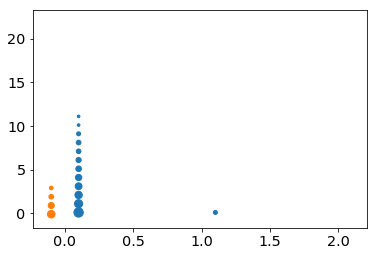

In [235]:
plot_2d_discrete(wt_data, offset=0.1)
plot_2d_discrete(ko_data, offset=-0.1)

### Combine

In [165]:
combined_df = ifn_df.merge(cd4_df, on=['gene_1', 'gene_2'], suffixes=('_ifn', '_ko'), how='inner')

In [167]:
combined_df.query('fdr_ifn < 0.2 & fdr_ko < 0.2')

,gene_1,gene_2,corr_1_ifn,corr_2_ifn,pval_ifn,fdr_ifn,corr_1_ko,corr_2_ko,pval_ko,fdr_ko,guide,target_gene
419,STAT6,CD83,-0.026335,0.104007,7.999200e-04,0.064309,-0.025533,-0.940701,1.999800e-04,3.744431e-03,STAT6.57102489,STAT6
481,STAT6,IGSF6,-0.078788,0.283258,1.365325e-06,0.000362,0.022396,-0.648600,6.999300e-03,7.094018e-02,STAT6.57102489,STAT6
821,IRF1,GNLY,-0.002020,-0.020886,2.399760e-03,0.129930,0.026060,-0.028183,1.519848e-02,1.173620e-01,IRF1.132487047,IRF1
830,IRF1,RSAD2,0.002239,0.288465,2.199780e-03,0.121584,0.104536,-0.172748,7.999200e-04,1.334385e-02,IRF1.132487119,IRF1
896,IRF1,MT2A,-0.050514,-0.305763,1.506597e-06,0.000363,0.149962,0.017477,5.199480e-03,5.566987e-02,IRF1.132487119,IRF1
1347,IRF1,UBQLN1,0.078492,0.313303,5.399460e-03,0.193578,0.287055,-0.328091,1.999800e-04,3.909579e-03,IRF1.132487047,IRF1
1353,IRF1,CLPTM1,-0.176139,0.112993,1.599840e-03,0.098706,0.397142,-0.183918,1.880431e-06,8.277734e-05,IRF1.132487047,IRF1
1369,IRF1,IRF8,-0.000021,0.147860,5.199480e-03,0.191586,0.011753,0.244058,1.739826e-02,1.272107e-01,IRF1.132487119,IRF1
1442,IRF8,HLA-DRB5,-0.003385,-0.019949,1.399860e-03,0.090581,0.058729,-0.035245,1.399860e-02,1.480218e-01,IRF8.85909118,IRF8
1457,IRF8,PARP1,-0.027707,0.184461,3.799620e-03,0.170854,0.096020,-0.101578,1.479852e-02,1.536650e-01,IRF8.85909118,IRF8


In [144]:
ko_data = cd4_adata[cd4_adata.obs.group == 'IRF1.132487047'][:, ['IRF1', 'STAT3']].X.toarray()
wt_data = cd4_adata[cd4_adata.obs.group == 'WT'][:, ['IRF1', 'STAT3']].X.toarray()

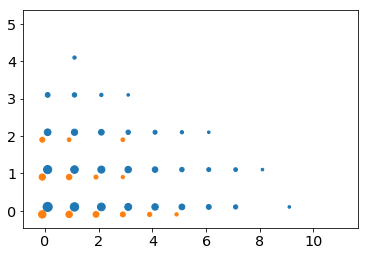

In [148]:
plot_2d_discrete(wt_data, offset=0.1)
plot_2d_discrete(ko_data, offset=-0.1)

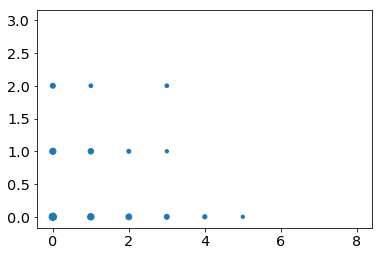

In [146]:
plot_2d_discrete(ko_data)

In [159]:
cd4_df.sort_values('corr_1', ascending=False).head(50)

,gene_1,gene_2,corr_1,corr_2,pval,fdr,guide,target_gene
1971,STAT3,FLT3LG,0.468973,-0.221384,2.799720e-03,0.037724,STAT3.42333711,STAT3
1814,STAT3,PRKD2,0.467586,-0.563677,1.199880e-03,0.019122,STAT3.42333711,STAT3
6301,IRF1,STAT3,0.441390,0.056915,2.359764e-02,0.154868,IRF1.132487047,IRF1
6607,IRF1,GBP4,0.407246,0.117311,9.544011e-06,0.000290,IRF1.132487047,IRF1
6607,IRF1,GBP4,0.407246,0.146157,3.219678e-02,0.188167,IRF1.132487119,IRF1
1904,STAT3,PIK3R1,0.402614,-0.062539,2.819718e-02,0.194134,STAT3.42333711,STAT3
6606,IRF1,CLPTM1,0.397142,-0.183918,1.880431e-06,0.000083,IRF1.132487047,IRF1
6401,IRF1,FLT3LG,0.365048,0.139053,2.959704e-02,0.181194,IRF1.132487047,IRF1
6388,IRF1,LAT,0.360150,0.118291,7.999200e-04,0.013344,IRF1.132487119,IRF1
6448,IRF1,CD320,0.360024,0.153330,2.259774e-02,0.151534,IRF1.132487047,IRF1


In [45]:
cd4_df[-1].head(5)

,gene_1,gene_2,corr_1,corr_2,guide
0,FOXP1,KIF22,0.209812,0.071911,STAT6.57102489
1,FOXP1,CPNE3,0.022734,-0.102944,STAT6.57102489
2,FOXP1,TESPA1,0.264540,0.704462,STAT6.57102489
3,FOXP1,LST1,-0.025428,0.584387,STAT6.57102489
4,FOXP1,IRAK4,0.214756,-0.106488,STAT6.57102489


In [31]:
cd4_results['FOXP1.71015617']#['dc_diff'].shape

{'dc_diff': array([[ 0.00779577, -0.21263905,  0.0322345 , ..., -0.37233696,
          0.29551512, -0.12590405],
        [-0.15537908,  0.0793148 , -0.11611821, ..., -0.08069982,
          0.70907005,  0.44325947],
        [-0.43918897, -0.53157142,  0.06518369, ...,  0.2517295 ,
         -0.24332548, -0.51201363],
        ...,
        [-0.18412935, -0.06615818, -0.27636927, ...,  0.11459017,
         -0.13387097, -0.03772737],
        [ 0.08721536,  0.36184987,  0.30691927, ...,  0.23397638,
          0.94735732,  0.16213627],
        [-0.21705082, -0.25417914, -0.15442412, ..., -0.05015697,
         -0.24963832, -0.2606947 ]]),
 'dc_pval': array([[9.83101690e-01, 2.02979702e-01, 8.02119788e-01, ...,
         3.79962004e-02, 4.19958004e-02, 4.42155784e-01],
        [3.38966103e-01, 8.57914209e-01, 6.90730927e-01, ...,
         7.46525347e-01, 4.29957004e-02, 2.25377462e-01],
        [2.60742514e-06, 1.99980002e-04, 8.55914409e-01, ...,
         7.80521948e-01, 2.19978002e-03, 5.799420

In [38]:
genes_to_test

['FOXP1',
 'STAT6',
 'JUN',
 'NCOA4',
 'STAT3',
 'NCOA3',
 'JUNB',
 'IRF4',
 'STAT1',
 'BATF',
 'IRF8',
 'IFI16',
 'IRF2',
 'ETS1',
 'IRF1',
 'STAT5A',
 'SATB1']